### Real-Data Benchmarking

This notebook goes over a collection of estimators used to model trend (change in mean) across a time series. Specifically a focus is on trend filtering and it's performance in estimation and computation time against splines, kernels, and segmented regression

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append("../")


PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)

os.listdir(PATH)[:20]

['CNC_reconstructed_features.csv',
 'ABBV_reconstructed_features.csv',
 'BWA_reconstructed_features.csv',
 'GOOG_reconstructed_features.csv',
 'AVGO_reconstructed_features.csv',
 'AME_reconstructed_features.csv',
 'CPT_reconstructed_features.csv',
 'BAX_reconstructed_features.csv',
 'BDX_reconstructed_features.csv',
 'AFL_reconstructed_features.csv',
 'CNP_reconstructed_features.csv',
 'CE_reconstructed_features.csv',
 'ANET_reconstructed_features.csv',
 'APD_reconstructed_features.csv',
 'ADBE_reconstructed_features.csv',
 'BAC_reconstructed_features.csv',
 'AES_reconstructed_features.csv',
 'CHTR_reconstructed_features.csv',
 'ADM_reconstructed_features.csv',
 'CDAY_reconstructed_features.csv']

In [2]:
os.listdir(PATH)

DATA_FILE = "AMZN_reconstructed_features.csv"

In [3]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0,nrows=12000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


### Screening by sale condtion of trades

- Examining only regular trades allows for a much better performace in terms of efficiency and estimation



In [4]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

print("Number of trades: ", len(regular_trades))

Number of trades:  591


In [5]:
trade_data["Sale_Condition"].unique()

array(['@  I', '@F I', '@  Q', '@ TI', '@O X', '@   ', '@F  ', '@4 I',
       '@4 W', '@ ZI', 'R  W'], dtype=object)

### Visualizing Market Data

Plotted below is AMZN trade price and volume data 

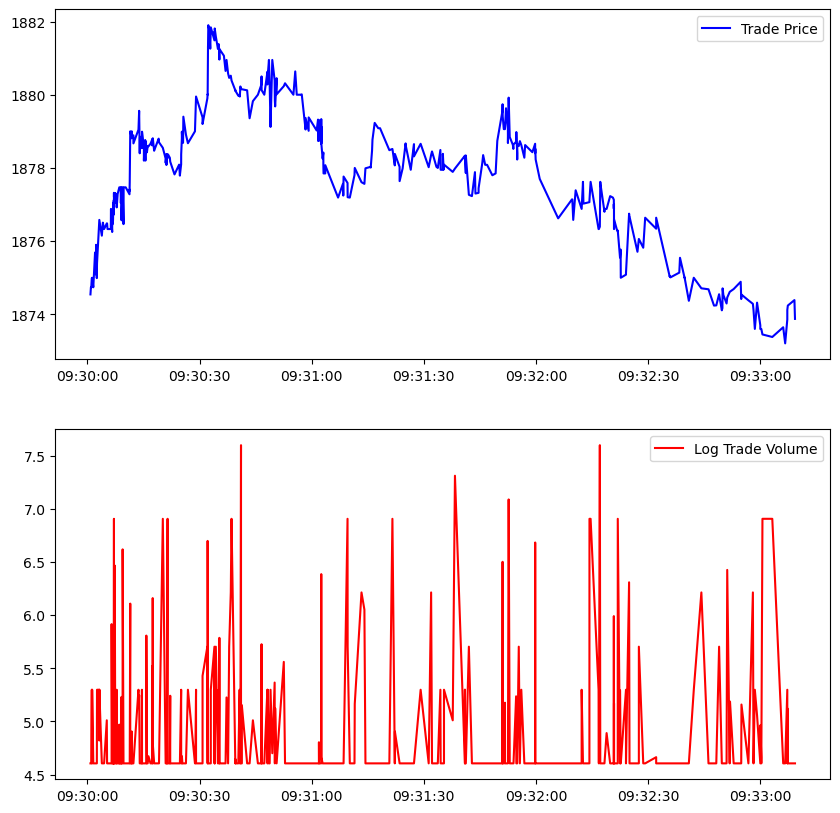

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

trade_price=regular_trades["Trade_Price"]
trade_volume=regular_trades["Trade_Volume"]


ax[0].plot(trade_price, label="Trade Price",color='blue')

ax[1].plot(np.log(trade_volume), label="Log Trade Volume",color='red')

ax[0].legend()
ax[1].legend()

plt.show()



### Quick Performance of Trend Filtering

In [7]:
import sys
sys.path.append("../../")
from estimators.trend_filtering.trend_filter import Trend_Filter

from estimators.cv_base_estimator import cv_base_estimator

In [8]:
x=np.arange(0,len(regular_trades))


tf= Trend_Filter(x=x, y=regular_trades["Trade_Price"].values, k=1, method="primal_dual")

cv_base_estimator(tf)



Performing  0 out of 3 iterations of cross validation
[  0   1   3   4   5   6   9  13  15  16  17  19  21  24  25  26  27  28
  29  33  34  35  37  38  39  42  43  45  47  49  51  52  53  55  56  57
  58  59  60  61  62  63  64  67  68  69  70  72  73  74  76  77  78  79
  80  82  83  85  87  88  89  93  96  97  98  99 102 103 105 106 107 108
 109 112 113 115 117 118 119 120 121 122 123 124 126 127 128 129 131 132
 133 135 136 137 140 141 143 144 145 147 148 149 151 152 153 156 157 158
 159 160 162 165 166 167 168 169 171 172 173 174 175 176 177 179 181 184
 185 186 187 188 190 192 194 195 196 198 199 200 202 203 205 208 210 213
 215 217 218 220 221 222 223 224 225 228 231 232 234 235 236 237 238 239
 241 244 245 246 247 248 249 251 252 253 255 256 257 258 259 261 264 266
 267 269 270 275 279 280 282 283 284 285 286 287 289 291 293 294 295 297
 299 303 304 306 307 308 309 310 311 312 313 315 316 317 318 319 320 321
 322 323 325 326 327 328 331 332 333 335 336 338 341 342 343 344 345 3

{'lambda_': 7.5980141531576555}

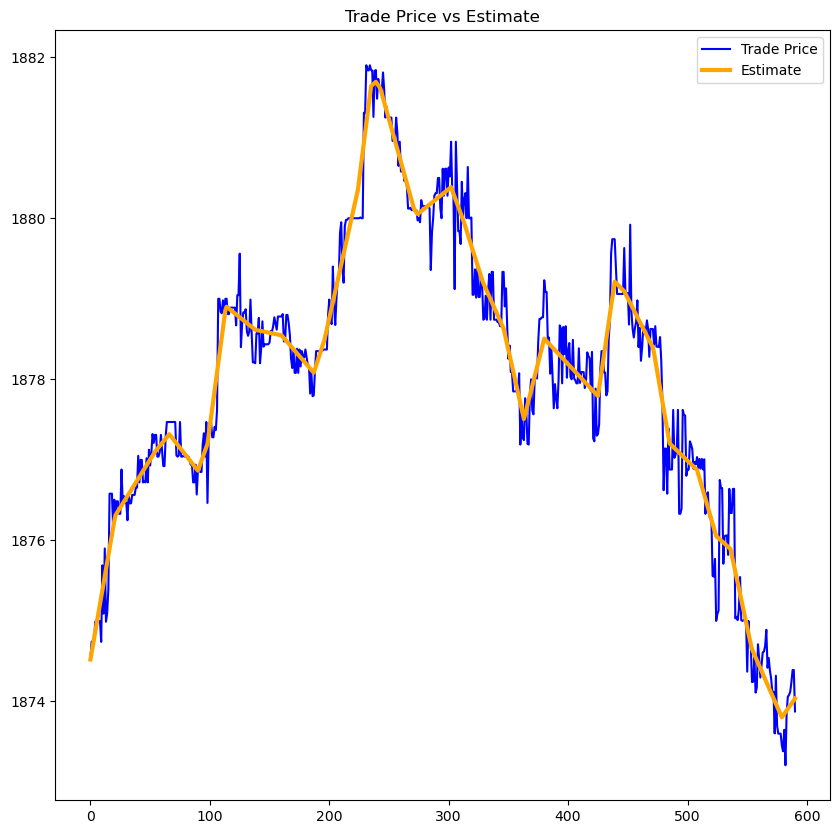

In [9]:


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.values, label="Trade Price",color='blue')

ax.plot(tf.y_hat, label="Estimate",lw=3,color='orange')

ax.legend()

ax.set_title("Trade Price vs Estimate")

plt.show()

### Regime Detection from Estimated Trend

In [10]:
from estimators.regression.piecewise_polynomial import Piecewise_Polynomial_Model

In [11]:
regime_model=Piecewise_Polynomial_Model(x=x, y=tf.y_hat, k=1, method="continous_tf")

[ 89 113 186 234 301 362 379 424 438 484 535 578]
{1: [234], 2: [234, 438], 3: [234, 424, 438], 4: [234, 379, 424, 438], 5: [113, 186, 234, 424, 438], 6: [113, 186, 234, 379, 424, 438], 7: [89, 113, 186, 234, 379, 424, 438], 8: [113, 186, 234, 301, 362, 379, 424, 438], 9: [89, 113, 186, 234, 301, 362, 379, 424, 438], 10: [89, 113, 186, 234, 301, 362, 379, 424, 438, 578], 11: [89, 113, 186, 234, 301, 362, 379, 424, 438, 535, 578], 12: [89, 113, 186, 234, 301, 362, 379, 424, 438, 484, 535, 578], 0: []}
k: 0 mse: 2.9918399180038864
k: 1 mse: 0.8643647681769195
k: 2 mse: 0.5701368483779995
k: 3 mse: 0.4992474405002983
k: 4 mse: 0.44077951806634297
k: 5 mse: 0.37749858854619506
k: 6 mse: 0.31903066611223974
k: 7 mse: 0.3073661554704511
k: 8 mse: 0.2976272622694937
k: 9 mse: 0.28596275162770507
k: 10 mse: 0.27981529211294864
k: 11 mse: 0.2901493700850182
k: 12 mse: 0.2964575048015725


In [12]:
regime_model.all_models

{0: 0.2889074254860573,
 1: 0.6596021371631183,
 2: 0.8756624693187667,
 3: 0.8828878874664549,
 4: 0.8564340516597613,
 5: 0.8451175071696976,
 6: 0.9634376507314037,
 7: 0.968315011175999,
 8: 0.9608083259818224,
 9: 0.9785025865090297,
 10: 1.0369317841567363,
 11: 1.0217409905618817}

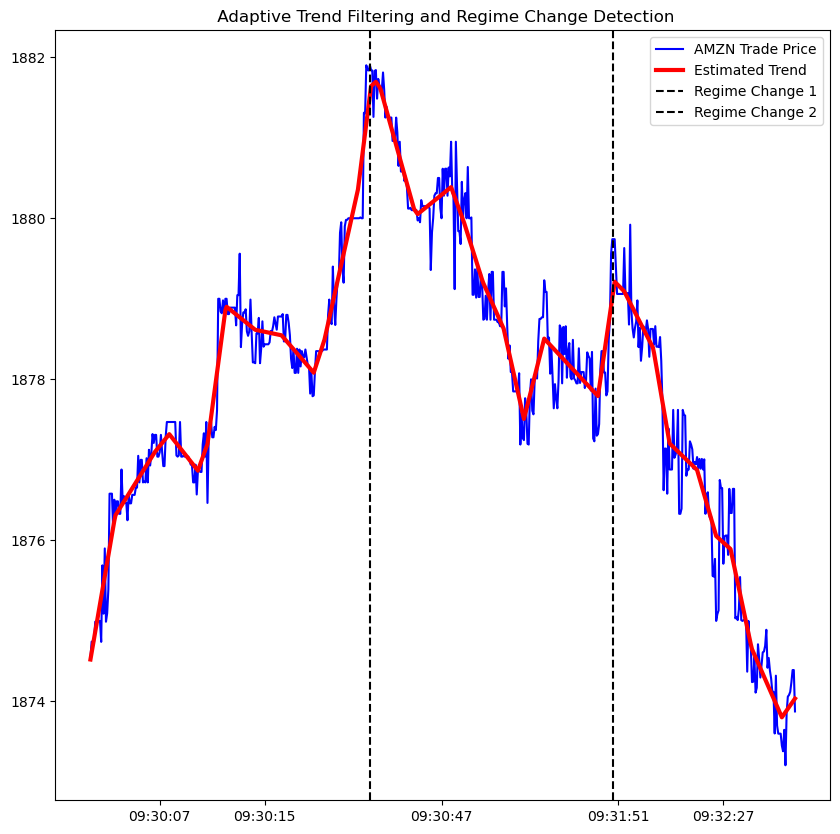

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.values, label="AMZN Trade Price",color='blue')
ax.plot(tf.y_hat, label="Estimated Trend ",color='red',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price.values)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Ratio of Loss Functions (Used for Model Selection)

In [14]:
model_selection=regime_model.all_models

model_selection

{0: 0.2889074254860573,
 1: 0.6596021371631183,
 2: 0.8756624693187667,
 3: 0.8828878874664549,
 4: 0.8564340516597613,
 5: 0.8451175071696976,
 6: 0.9634376507314037,
 7: 0.968315011175999,
 8: 0.9608083259818224,
 9: 0.9785025865090297,
 10: 1.0369317841567363,
 11: 1.0217409905618817}

Text(0.5, 1.0, 'Model Selection')

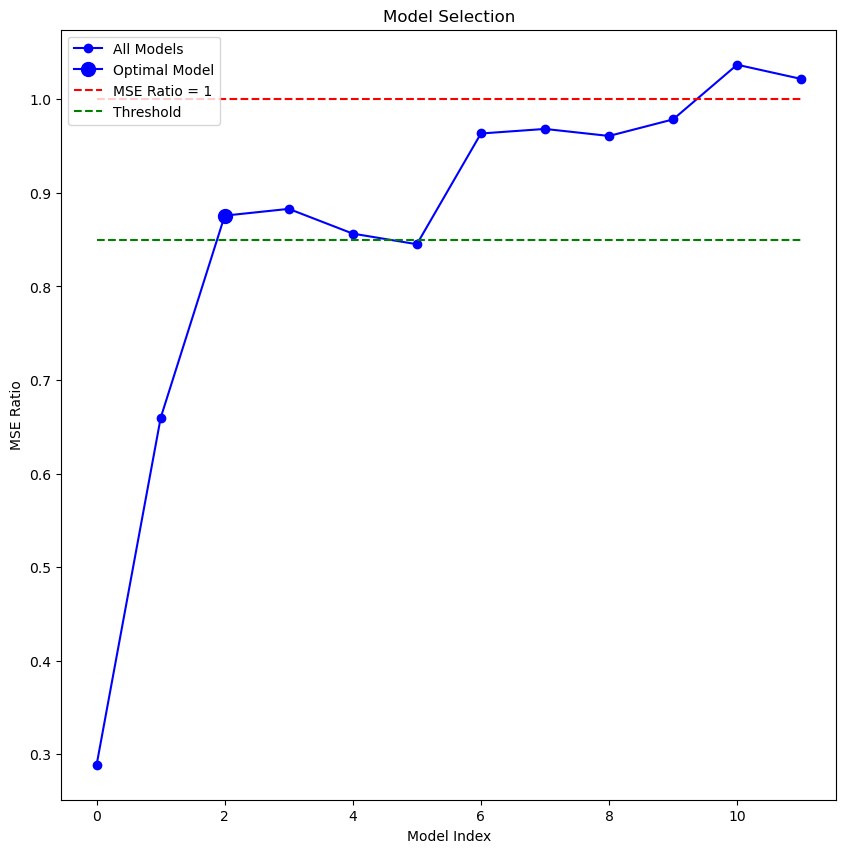

In [15]:
keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i !=regime_model.optimal_model]


nu=regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(regime_model.optimal_model,model_selection[regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")



### Time Dependent Trend Filtering

Careful consideration to round timestamps for observations with near identical timestamps

In [16]:
regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')

round_regular_trades = regular_trades.groupby('Round_Timestamp').agg({'Trade_Price': 'mean', 'Trade_Volume': 'sum'})

round_regular_trades.head()

/tmp/ipykernel_101107/2014949561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')


,Trade_Price,Trade_Volume
Round_Timestamp,,
2020-01-02 09:30:00.820,1874.5450,100.0
2020-01-02 09:30:00.948,1874.7425,200.0
2020-01-02 09:30:01.040,1874.7400,100.0
2020-01-02 09:30:01.160,1874.9900,200.0
2020-01-02 09:30:01.180,1874.9900,200.0


In [17]:
time_trade_price=round_regular_trades["Trade_Price"]

timestamps=round_regular_trades.index-regular_trades.index[0]

timestamps=timestamps.total_seconds().values




In [18]:
time_tf= Trend_Filter(x=timestamps, y=time_trade_price.values, k=1, method="primal_dual")

cv_base_estimator(time_tf)

time_tf.hypers

Performing  0 out of 3 iterations of cross validation
[  0.      0.36    0.457   0.762   1.231   1.474   1.512   1.698   1.713
   1.755   2.374   3.048   3.323   3.652   4.372   4.447   5.497   5.517
   5.648   5.659   5.818   5.82    6.042   6.056   6.066   6.143   6.259
   6.26    6.29    6.291   6.65    6.956   7.022   7.722   8.076   8.138
   8.315   8.32    8.323   8.451   8.604   8.609   8.878   9.436  10.448
  10.459  10.466  10.51   10.649  11.036  11.042  11.047  11.49   12.847
  12.849  13.028  13.218  13.247  13.548  13.738  13.754  13.755  14.3
  14.301  14.451  14.714  14.852  14.912  14.955  14.956  15.104  15.152
  15.315  15.517  16.496  16.503  16.658  16.683  17.044  18.244  18.253
  18.342  19.363  20.119  20.322  20.451  20.636  20.67   21.245  22.49
  23.728  23.933  24.268  24.274  24.457  24.459  24.778  24.859  25.549
  26.079  27.963  28.043  28.253  31.28   31.349  31.351  31.36   31.526
  31.536  31.542  31.752  32.059  32.201  32.202  33.245  33.246  33.252


defaultdict(float, {'lambda_': 16.5825349430527})

In [19]:
time_regime_model=Piecewise_Polynomial_Model(x=timestamps, y=time_tf.y_hat, k=1, method="continous_tf")

[ 86 136 167 221 251 300 323]
{1: [167], 2: [167, 300], 3: [167, 251, 323], 4: [167, 221, 251, 323], 5: [86, 136, 167, 251, 323], 6: [86, 136, 167, 221, 251, 323], 7: [86, 136, 167, 221, 251, 300, 323], 0: []}
k: 0 mse: 2.820122912369099
k: 1 mse: 0.6408101431265535
k: 2 mse: 0.4398886683123807
k: 3 mse: 0.2763688045864818
k: 4 mse: 0.2654949633155742
k: 5 mse: 0.205123824267559
k: 6 mse: 0.19424998299665144
k: 7 mse: 0.184065604126715


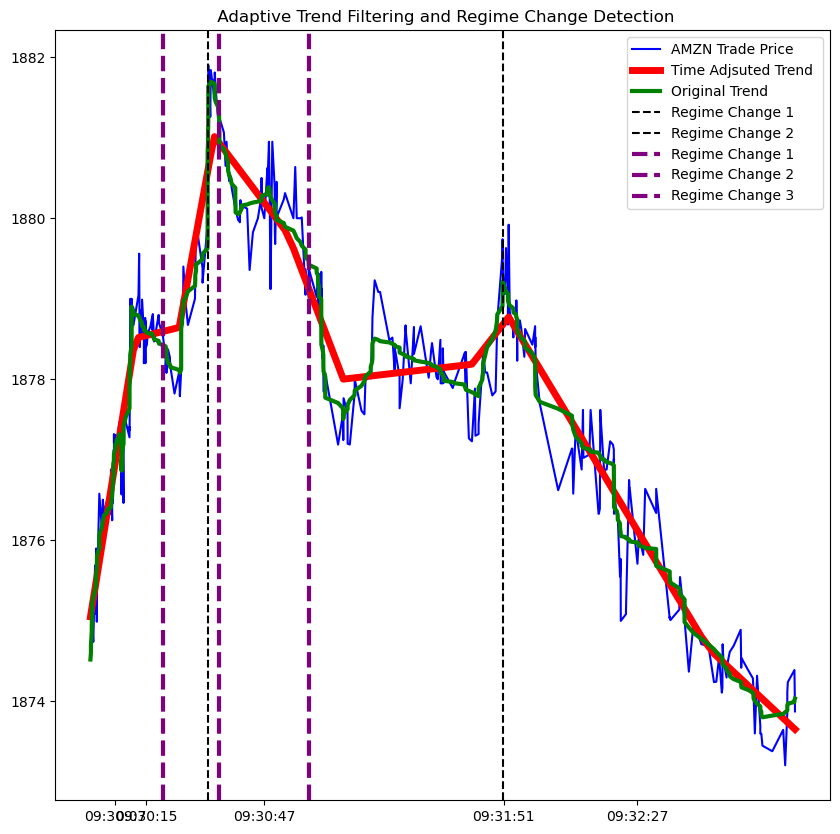

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.index,trade_price.values, label="AMZN Trade Price",color='blue')
ax.plot(time_trade_price.index,time_tf.y_hat, label="Time Adjsuted Trend ",color='red',lw=5)
ax.plot(trade_price.index,tf.y_hat, label="Original Trend",color='green',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(trade_price.index[regime_model.knots[i]],color='black',linestyle='--',label=f"Regime Change {i+1}")

for i in range(len(time_regime_model.knots)):
    ax.axvline(trade_price.index[time_regime_model.knots[i]],color='purple',linestyle='--',label=f"Regime Change {i+1}",lw=3)


ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price.values)*q)-1 for q in quantiles]
ax.set_xticks(trade_price.index[indices],regular_trades.index[indices].strftime("%H:%M:%S"))

Text(0.5, 1.0, 'Model Selection')

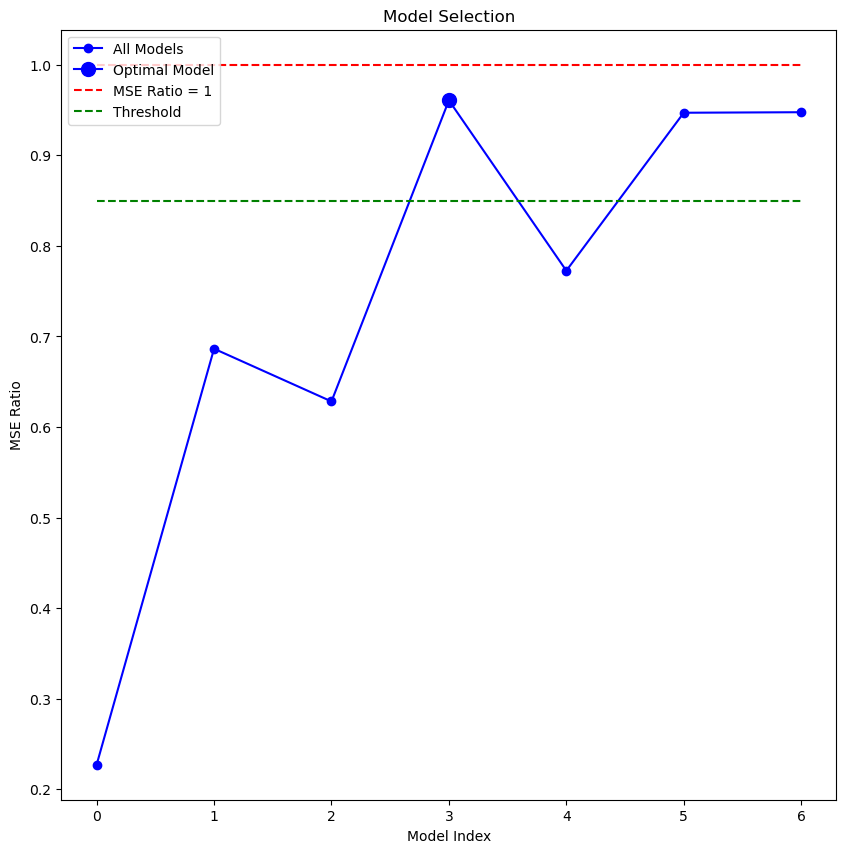

In [21]:
model_selection=time_regime_model.all_models

keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i != time_regime_model.optimal_model]

nu=time_regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(time_regime_model.optimal_model,model_selection[time_regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")
